## Keywords - Synthetic Lung Cancer
1. Shapley Flow
2. Independent SHAP
3. Kernel SHAP
4. On Manifold SHAP
5. ASV
6. Causal SHAP
7. The ground truth using Exact SHAP

In [ ]:
!pip install shapflow

In [ ]:
!pip install --config-settings="--global-option=build_ext" \
              --config-settings="--global-option=-IC:\Program Files\Graphviz\include" \
              --config-settings="--global-option=-LC:\Program Files\Graphviz\lib" \
              pygraphviz

In [2]:
from shapflow import flow
flow.example_concise() # running the sanity check example in flow.py
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from shapflow import flow
from shapflow.flow import Node, Graph, GraphExplainer
import pickle
import logging
# Set logging level to WARNING or ERROR
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
import shap
from on_manifold import OnManifoldExplainer, IndExplainer
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 12062.30it/s]

credit x2->target: [1.]
credit x1->x2: [1.]
credit x1->target: [1.]


### Shapley Flow

In [18]:
data_path = '../../dataset/Synthetic_Lung_Cancer.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=42)

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 4159.45it/s]


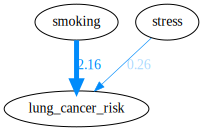

In [7]:
smoking = Node('smoking')
stress = Node('stress')
drink_coffee = Node(
    'drink_coffee',
    lambda smoking, stress: 0.940100 * smoking + 0.254443 * stress,
    [smoking, stress]
)
lung_cancer_risk = Node(
    'lung_cancer_risk',
    lambda smoking, stress: 0.789596 * smoking + 0.233254 * stress,
    [smoking, stress],
    is_target_node=True
)

graph = Graph([smoking, stress, drink_coffee, lung_cancer_risk])

bg_sample = pd.DataFrame([X_train[['smoking', 'stress', 'drink_coffee']].mean()])
lung_cancer_risk_95th_pct = np.quantile(y_test, 0.95)
fg_idx = np.where(y_test >= lung_cancer_risk_95th_pct)[0]
fg_sample = pd.DataFrame(X_test.iloc[fg_idx][['smoking', 'stress', 'drink_coffee']])

graph_explainer = GraphExplainer(graph, bg_sample)

shapley_flow_results = graph_explainer.shap_values(fg_sample)
shapley_flow_results.draw()
print(shapley_flow_results)

### Independent SHAP

In [38]:
bg = pd.DataFrame([X_train[['smoking', 'stress', 'drink_coffee']].mean()], columns=['smoking', 'stress', 'drink_coffee'])
lung_cancer_risk_95th_pct = np.quantile(y_test, 0.95)
fg_idx = np.where(y_test >= lung_cancer_risk_95th_pct)[0]
fg = pd.DataFrame(X_test.iloc[fg_idx][['smoking', 'stress', 'drink_coffee']], columns=['smoking', 'stress', 'drink_coffee'])

cf_ind = IndExplainer(rf.predict, bg, silent=True).shap_values(fg)

print(cf_ind.values.mean(axis=0))

[[3.94673239]
 [0.1031798 ]
 [1.81637029]]


### Kernel SHAP

In [42]:
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
shap_values = explainer.shap_values(fg)

print(shap_values.mean(axis=0))

100%|██████████| 12/12 [00:00<00:00, 13.85it/s]

[3.24051756 0.36208727 1.95141213]


### On Manifold SHAP

In [47]:
cf_onm = OnManifoldExplainer(rf.predict, pd.concat([bg, fg]), silent=True).shap_values(fg)
print(cf_onm.values.mean(axis=0))

[[2.01046003]
 [1.87593905]
 [1.97988341]]


### ASV

In [48]:
# ASV: restricting the order of on manifold methods
cf_asv = OnManifoldExplainer(rf.predict, pd.concat([bg, fg]), orderings=[[0, 1, 2]], silent=True).shap_values(fg)
print(cf_asv.values.mean(axis=0))

[[ 5.93665087]
 [-0.08050945]
 [ 0.01014107]]


### Exact SHAP Explainer

In [11]:
data_path = '../../dataset/Synthetic_Lung_Cancer.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk', 'drink_coffee'])
y = df['lung_cancer_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

lung_cancer_risk_95th_pct = np.quantile(y_test, 0.95)
fg_idx = np.where(y_test >= lung_cancer_risk_95th_pct)[0]
fg_sample = pd.DataFrame(X_test.iloc[fg_idx][['smoking', 'stress']])

explainer = shap.ExactExplainer(rf.predict, X_train)

exact_reduced_shap_values = explainer(fg_sample)

print(exact_reduced_shap_values.values.mean(axis=0))

[5.21714586 0.25075845]


### Causal SHAP

In [15]:
file_path = '../../result/R/Causal_SHAP_LC_42_Dec.pkl'
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

data_path = '../../../dataset/Synthetic_Lung_Cancer.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

causal_shap_values = load_and_format_shap_values(file_path, feature_names)

print(causal_shap_values[fg_idx].mean(axis=0))

[5.34620333 0.26001281 0.        ]
